In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, \
    mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
train = pd.read_csv('../data/train_02032024.csv', index_col=0)
test = pd.read_csv('../data/test_02032024.csv', index_col=0)

In [4]:
train['group_model_year_level'] = train['brand'] + '_' + train['model'] + '_' + train['registration_year'].astype(int).astype(str)
train['group_model_level'] = train['brand'] + '_' + train['model']
train['group_year_level'] = train['brand'] + '_' + train['registration_year'].astype(int).astype(str)

In [5]:
test['group_model_year_level'] = test['brand'] + '_' + test['model'] + '_' + test['registration_year'].astype(int).astype(str)
test['group_model_level'] = test['brand'] + '_' + test['model']
test['group_year_level'] = test['brand'] + '_' + test['registration_year'].astype(int).astype(str)

In [6]:
train_validation, test_validation = train_test_split(train, test_size=0.15, random_state=42)

In [7]:
cols_to_drop1 = [x for x in train.columns if 'extra' in x]
cols_to_drop2 = [
    'lat',
    'lon',
    'uuid',
    'label',
    'model_stub',
    'thumbs',
    'price_debatable',
    'user_id',
    'title',
    'without_vat',
    'seller',
    'created',
    'seo_json_ld',
     'address_long',
    'modified',
    'battery_range',
    'variant']


In [8]:
train_val_subset = train_validation.drop(columns=cols_to_drop1 + cols_to_drop2).copy()
test_val_subset = test_validation.drop(columns=cols_to_drop1 + cols_to_drop2).copy()
test_subset = test.drop(columns=cols_to_drop1 + cols_to_drop2).copy()

# Base model

We group by three levels:

* brand, model , year
* brand, model
* brand

For each point in the test set we look at the corresponding group at the most granular level (brand, model, year) if there are enough points in the group (count > threshold) we estimate the price as the median price of the corresponding group in the training set. If the number of points in the train set is lower than the threshold then we move to a group level with higher granularity. If the brand in question doesn't exist in the training set, we predict the median price of the training set.

In [9]:
count_model_year_level = train.groupby('group_model_year_level')['group_model_year_level'].count()
count_model_level = train.groupby('group_model_level')['group_model_level'].count()
count_year_level = train.groupby('group_year_level')['group_year_level'].count()
count_brand_level = train.groupby('brand')['brand'].count()

In [10]:
def predict(row, train_set,thresh):
    model_year = row['group_model_year_level']
    model_level = row['group_model_level']
    year_level = row['group_year_level']
    if (model_year in count_model_year_level) and count_model_year_level[model_year] >= thresh:
        return train_set.loc[train_set['group_model_year_level'] == model_year,'raw_price'].median(), 'group_model_year_level'
    elif (model_level in count_model_level) and count_model_level[model_level] >= thresh:
        return train_set.loc[train_set['group_model_level'] == model_level,'raw_price'].median(), 'group_model_level'
    elif (year_level in count_year_level) and count_year_level[year_level] >= thresh:
        return train_set.loc[train_set['group_year_level'] == year_level,'raw_price'].median(), 'group_year_level'
    else:
        return train_set.loc[train_set['brand'] == row.brand,'raw_price'].median(), 'brand_level'

In [45]:
def test_thresholds(threshs,test_set):
    ape = []
    df = test_set.copy()
    for thresh in tqdm(threshs):
        df[['base_model_pred','used_level']] = df.apply(lambda row: pd.Series(predict(row, train, thresh)), axis=1)
        df['ape'] = abs(df['raw_price'] - df['base_model_pred'])/df['raw_price']
        ape.append(df['ape'].mean())
    return ape




In [48]:
threshs = np.linspace(0, 100, 21)
apes = test_thresholds(threshs, test)

100%|██████████| 21/21 [22:40<00:00, 64.78s/it]


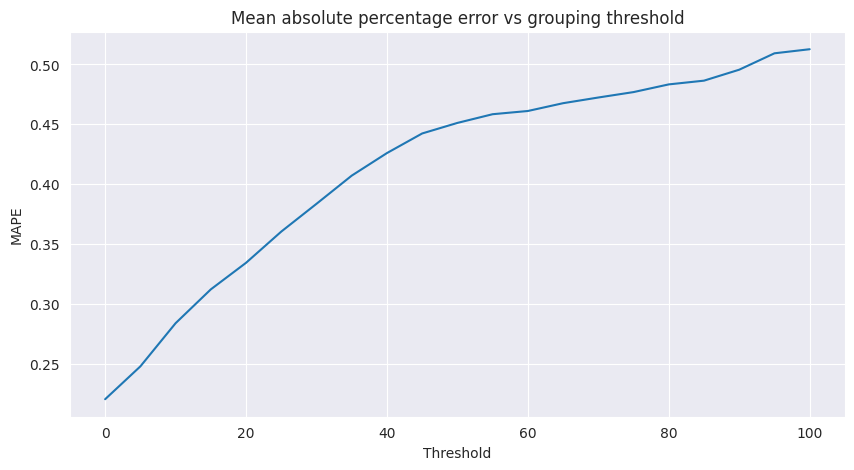

In [52]:
plt.figure(figsize=(10,5))
plt.plot(threshs, apes)
plt.xlabel('Threshold')
plt.ylabel('MAPE')
plt.title('Mean absolute percentage error vs grouping threshold')
plt.savefig('../plots/group_median_thresh.png', bbox_inches='tight')

In [53]:
test[['base_model_pred','used_level']] = test.apply(lambda row: pd.Series(predict(row, train, 1)), axis=1)
test['residuals_median'] = test['raw_price'] - test['base_model_pred']
test['abs_residuals_median'] = abs(test['raw_price'] - test['base_model_pred'])
test['ape_median'] = abs(test['raw_price'] - test['base_model_pred'])/test['raw_price']
print(f"RMSE: {root_mean_squared_error(test['raw_price'], test['base_model_pred'])}")
print(f"MSE: {mean_squared_error(test['raw_price'], test['base_model_pred'])}")
print(f"MAE: {mean_absolute_error(test['raw_price'], test['base_model_pred'])}")
print(f"MAPE: {mean_absolute_percentage_error(test['raw_price'], test['base_model_pred'])}")

RMSE: 6843.542134128008
MSE: 46834068.94158533
MAE: 2740.671053928818
MAPE: 0.2205557915268146


In [54]:
test.loc[:,['base_model_pred','residuals_median','abs_residuals_median','ape_median']].to_csv('../data/experiment_results/base_model_res.csv')

So our basic model gives us an mean absolute percentage error of 22% and an MAE of 2740. Let's analyze the errors

(-30000.0, 30000.0)

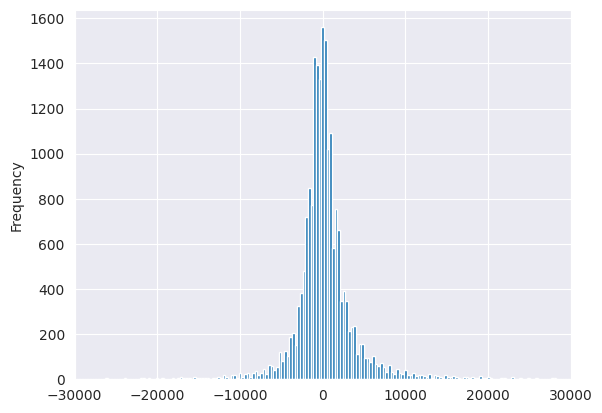

In [81]:
test.residuals_median.plot(kind='hist',bins=1000)
plt.xlim([-30000, 30000])

In [59]:
print(pd.concat([test.residuals_median.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),test.abs_residuals_median.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),test.ape_median.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])],axis=1).to_markdown())

|       |   residuals_median |   abs_residuals_median |     ape_median |
|:------|-------------------:|-----------------------:|---------------:|
| count |          20286     |               20286    | 20286          |
| mean  |            537.334 |                2740.67 |     0.220556   |
| std   |           6822.58  |                6270.94 |     0.585012   |
| min   |        -120000     |                   0    |     0          |
| 1%    |         -12499.1   |                   0    |     0          |
| 5%    |          -4545     |                  99    |     0.00742092 |
| 10%   |          -2810     |                 200    |     0.02       |
| 25%   |          -1200     |                 550    |     0.05375    |
| 50%   |              0     |                1300    |     0.122727   |
| 75%   |           1480     |                2700    |     0.237179   |
| 90%   |           3990     |                5600    |     0.421623   |
| 95%   |           6750     |                9137.

In [82]:
pd.concat([test[test.ape_median> test.ape_median.quantile(0.97)].mileage.describe(),test.mileage.describe()],axis=1)

,mileage,mileage
count,6.090000e+02,2.028600e+04
mean,1.981556e+05,1.345912e+05
std,1.657935e+05,8.608825e+04
min,0.000000e+00,0.000000e+00
25%,1.000000e+05,7.900000e+04
50%,1.839000e+05,1.267270e+05
75%,2.540000e+05,1.800000e+05
max,1.400000e+06,1.400000e+06


In [63]:
pd.concat([test[test.ape_median> test.ape_median.quantile(0.97)].raw_price.describe(),test.raw_price.describe()],axis=1)

,raw_price,raw_price
count,609.000000,20286.000000
mean,6113.201970,15787.325840
std,14559.548368,17694.852723
min,600.000000,600.000000
25%,1500.000000,7200.000000
50%,2500.000000,11490.000000
75%,5000.000000,17950.000000
max,200000.000000,345000.000000


In [66]:
pd.concat([test[test.ape_median> test.ape_median.quantile(0.97)].raw_price.describe(),test.raw_price.describe()],axis=1)

,raw_price,raw_price
count,609.000000,20286.000000
mean,6113.201970,15787.325840
std,14559.548368,17694.852723
min,600.000000,600.000000
25%,1500.000000,7200.000000
50%,2500.000000,11490.000000
75%,5000.000000,17950.000000
max,200000.000000,345000.000000


In [79]:
test.loc[test.ape_median>test.ape_median.quantile(0.97),['mileage','registration_year','engine_power','engine_size','description','raw_price','base_model_pred','ape_median']].sort_values(by=['ape_median'],ascending=False).head(8)

,mileage,registration_year,engine_power,engine_size,description,raw_price,base_model_pred,ape_median
3351,0.0,2024,136.0,1119.0,χωρις προκαταβολη\n\nμισθωνοντας καποιο απο τα...,665.0,34600.0,51.030075
1385,100.0,2015,160.0,2143.0,το οχημα παρουσιαζεται σαν δειγμα δουλειας\n\n...,1000.0,24500.0,23.500000
61041,150000.0,2001,204.0,2500.0,"η τιμη αυτη ειναι μονο για μετρητα, και η αγορ...",1500.0,23000.0,14.333333
79827,20000.0,2021,160.0,2000.0,καλεστε για να ενημερωθειτε για ημερομηνιες κα...,3500.0,39900.0,10.400000
78073,150000.0,2006,110.0,1600.0,χωρις μηχανη σασμαν αμεσα μεταβιβασιμο,600.0,6250.0,9.416667
65857,200000.0,2002,65.0,1360.0,πωλειται για ανταλλακτικα,700.0,7000.0,9.000000
30625,780.0,2006,150.0,2200.0,αποχαρακτηρισμενο για ανταλλακτικα.\nη μηχανη ...,2500.0,24999.0,8.999600
36048,180587.0,2016,75.0,1600.0,1000euro συζητησιμη,1000.0,9900.0,8.900000


<Axes: xlabel='mileage', ylabel='raw_price'>

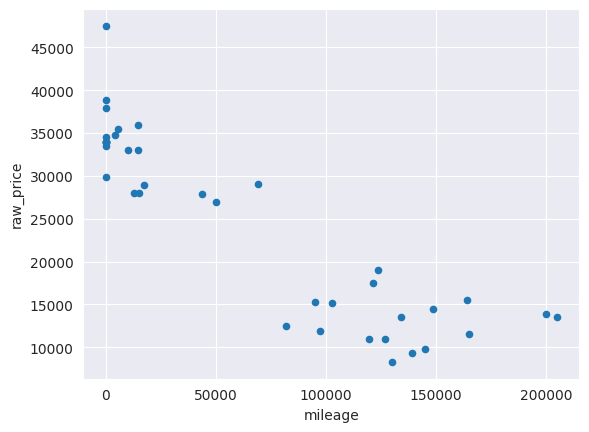

In [116]:
train.loc[train.group_model_level=='ds_ds4',['mileage','raw_price']].plot(kind='scatter', x='mileage', y='raw_price')

In [117]:
# Here we see that we make large errors for low prices

(0.0, 50000.0)

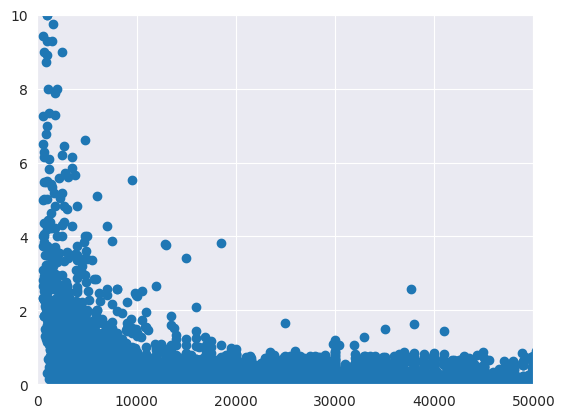

In [118]:
plt.scatter(test.raw_price, test.ape_median)
plt.ylim([0,10])
plt.xlim([0,50000])

In [119]:
#Here we see that we make errors on cars with very low mileage or high mileage (200 000)

(0.0, 1000000.0)

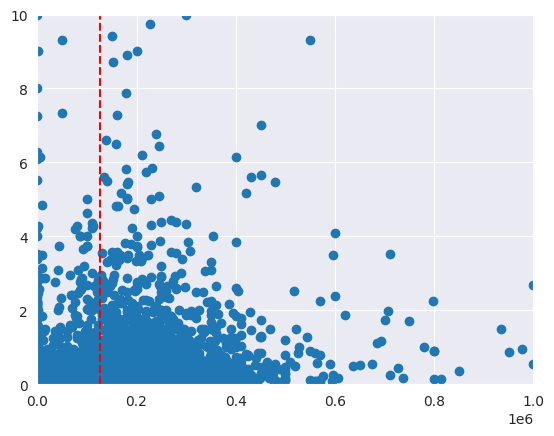

In [120]:
plt.scatter((test.mileage), test.ape_median)
plt.axvline(test.mileage.median(), color='red', linestyle='--')
plt.ylim([0,10])
plt.xlim([0,1000000])

In [121]:
# Here we see that we make errors on older cars

(0.0, 10.0)

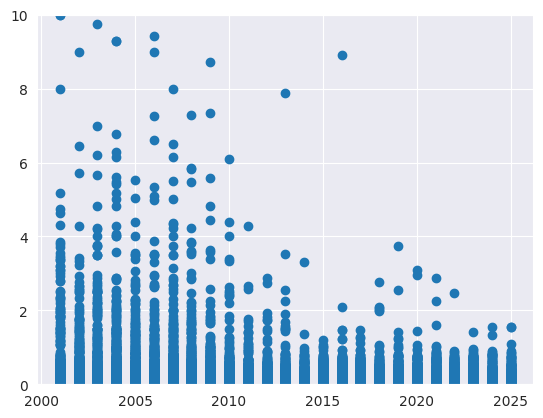

In [122]:
plt.scatter((test.registration_year), test.ape_median)
plt.ylim([0,10])

(0.0, 5.0)

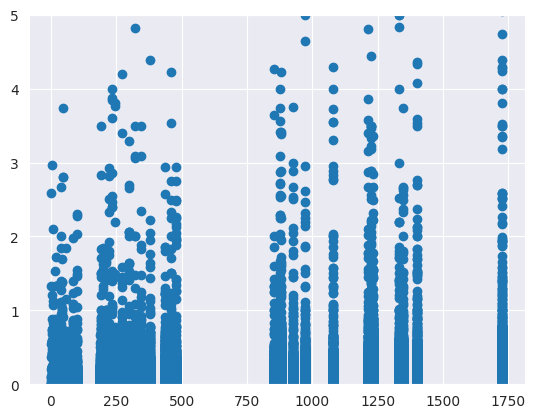

In [123]:
plt.scatter(test.groupby('brand')['brand'].transform('count'), test.ape_median)
plt.ylim([0,5])

(0.0, 2.0)

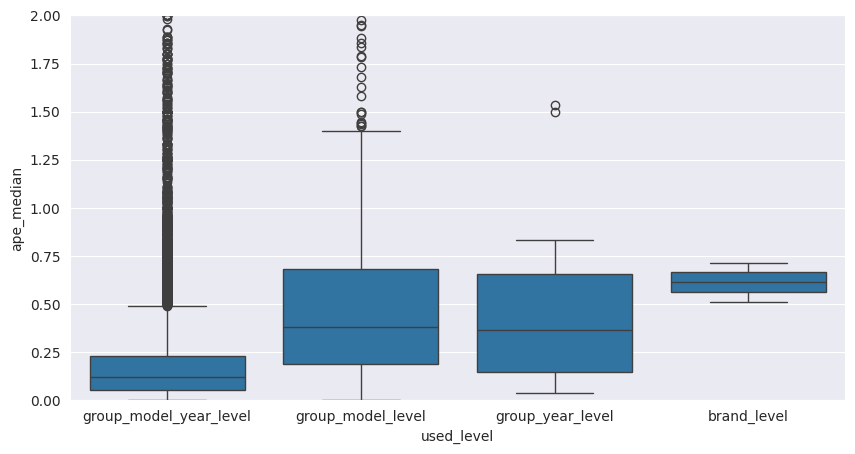

In [83]:
plt.figure(figsize=(10,5))
sns.boxplot(data=test,x='used_level',y='ape_median')
plt.ylim([0,2])

(0.0, 8.0)

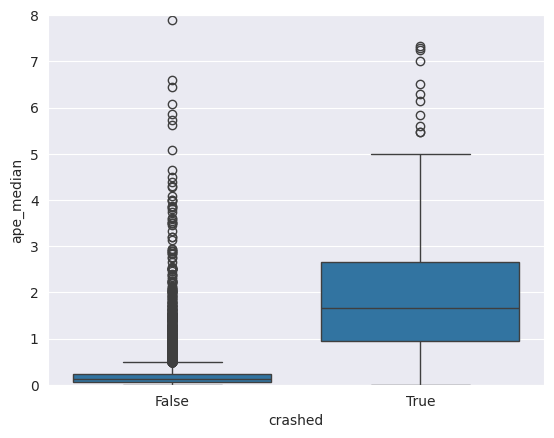

In [88]:
sns.boxplot(data=test,x='crashed',y='ape_median')
plt.ylim([0,8])

In [155]:
test.groupby('crashed')['ape'].apply(lambda x: x.describe([0.1])).unstack(0)

crashed,False,True
count,19985.000000,301.000000
mean,0.218467,2.206605
std,0.581416,1.973767
min,0.000000,0.000000
10%,0.020443,0.501926
50%,0.125016,1.727273
max,51.030075,14.000000


In [156]:
test.residuals.describe()

count     20286.000000
mean        946.284556
std        8779.771595
min      -97300.000000
25%       -1200.000000
50%           0.000000
75%        1509.000000
max      247999.000000
Name: residuals, dtype: float64

# Linear Regression

In [90]:
cols_to_keep = ['is_new', 'mileage', 'crashed',
       'raw_price', 'engine_size',
       'registration_year', 'engine_power', 'fuel_type', 'gearbox_type',
       'brand', 'model',
       'seats',  'exterior_color',  'doors', 'is_metallic',
       'group_model_year_level', 'group_model_level', 'group_year_level']

In [91]:
train_val_linreg =train_val_subset.loc[:, cols_to_keep].copy()
test_val_linreg = test_val_subset.loc[:, cols_to_keep].copy()

In [92]:
ohe_fuel = OneHotEncoder(handle_unknown='ignore', drop='first') #
ohe_gearbox = OneHotEncoder(handle_unknown='ignore', drop='first') #

In [133]:
train_val_linreg['is_new'] = train_val_linreg['is_new'].astype('int')
train_val_linreg['crashed'] = train_val_linreg['crashed'].astype('int')

train['is_new'] = train['is_new'].astype('int')
train['crashed'] = train['crashed'].astype('int')

In [132]:
test_val_linreg['is_new'] = test_val_linreg['is_new'].astype('int')
test_val_linreg['crashed'] = test_val_linreg['crashed'].astype('int')


test['is_new'] = test['is_new'].astype('int')
test['crashed'] = test['crashed'].astype('int')

<Axes: >

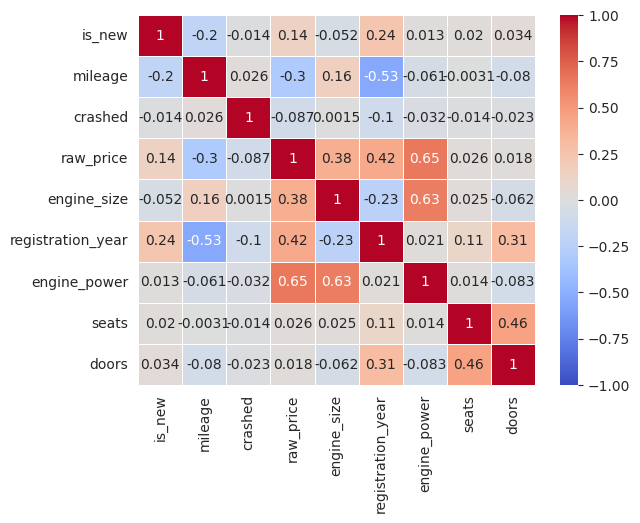

In [96]:
sns.heatmap(train_val_linreg.select_dtypes(include=[np.number]).corr(), annot=True, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1)

<Axes: ylabel='Frequency'>

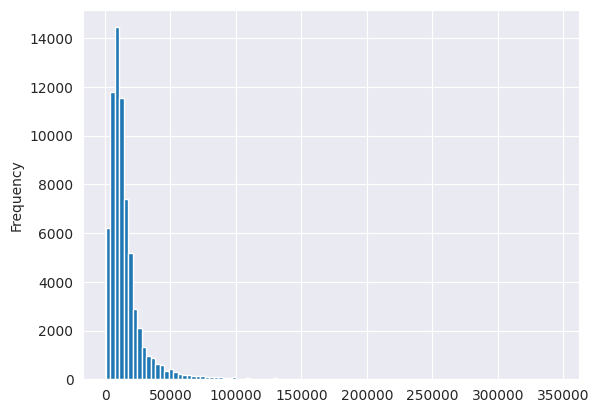

In [236]:
(train_val_linreg.raw_price).plot(kind='hist',bins=100)

<Axes: ylabel='Frequency'>

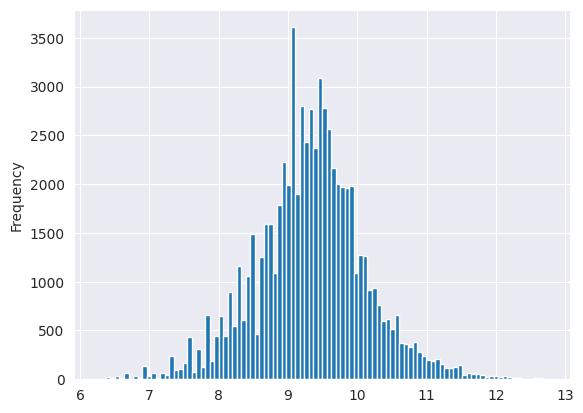

In [235]:
np.log(train_val_linreg.raw_price).plot(kind='hist',bins=100)

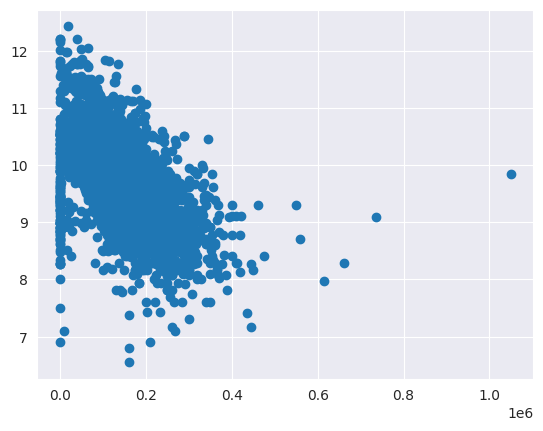

In [239]:
plt.scatter(train_val_linreg[train_val_linreg.brand=='audi'].mileage,(train_val_linreg[train_val_linreg.brand=='audi'].raw_price.apply(np.log)))

In [97]:
from tqdm import tqdm
import statsmodels.api as sm

In [98]:
cols_to_keep = ['mileage', 'engine_size','registration_year','crashed']

In [99]:
train_val_linreg['log_price'] = train_val_linreg['raw_price'].apply(np.log)

In [100]:
test_val_linreg['log_price'] = test_val_linreg['raw_price'].apply(np.log)

In [101]:
train_val_linreg.columns

Index(['is_new', 'mileage', 'crashed', 'raw_price', 'engine_size',
       'registration_year', 'engine_power', 'fuel_type', 'gearbox_type',
       'brand', 'model', 'seats', 'exterior_color', 'doors', 'is_metallic',
       'group_model_year_level', 'group_model_level', 'group_year_level',
       'log_price'],
      dtype='object')

In [102]:
train_val_linreg.drop(columns='const',inplace=True)

KeyError: "['const'] not found in axis"

In [115]:
test_val_linreg.group_model_level.head()

59638    citroen_c3 aircross
7918            dacia_duster
877          volkswagen_golf
30881           hyundai_i 20
21674           smart_fortwo
Name: group_model_level, dtype: object

In [103]:
dict_linreg_models = {}
dict_linreg_brands = {}
for group in tqdm(train_val_linreg.group_model_level.unique()):
    scaler = StandardScaler()
    X = scaler.fit_transform(((train_val_linreg.loc[train_val_linreg.group_model_level == group,cols_to_keep])))
    X = sm.add_constant(X)
    linreg = sm.OLS(train_val_linreg.loc[train_val_linreg.group_model_level == group,'log_price'],X)
    dict_linreg_models[group] = [linreg.fit(), scaler, train_val_linreg[train_val_linreg.group_model_level == group].shape[0]]

for group in tqdm(train_val_linreg.brand.unique()):
    scaler = StandardScaler()
    X = scaler.fit_transform((train_val_linreg.loc[train_val_linreg.brand == group,cols_to_keep]))
    X = sm.add_constant(X)
    linreg = sm.OLS(train_val_linreg.loc[train_val_linreg.brand == group,'log_price'],X)
    dict_linreg_brands[group] = [linreg.fit(), scaler,  train_val_linreg[train_val_linreg.brand == group].shape[0]]



100%|██████████| 69/69 [00:01<00:00, 59.50it/s]


,is_new,mileage,crashed,raw_price,engine_size,registration_year,engine_power,fuel_type,gearbox_type,brand,...,exterior_color,doors,is_metallic,group_model_year_level,group_model_level,group_year_level,log_price,prediction,abs_residual,ape
59638,0,53000.0,0,16990.0,1500.0,2022,110.0,diesel,manual,citroen,...,white,5.0,False,citroen_c3 aircross_2022,citroen_c3 aircross,citroen_2022,9.740380,17894.538172,904.538172,0.053239
7918,0,146725.0,0,10590.0,1461.0,2017,110.0,diesel,manual,dacia,...,black,5.0,False,dacia_duster_2017,dacia_duster,dacia_2017,9.267665,13881.023782,3291.023782,0.310767
877,0,380000.0,0,3000.0,1800.0,2002,193.0,petrol,manual,volkswagen,...,silver,2.0,True,volkswagen_golf_2002,volkswagen_golf,volkswagen_2002,8.006368,3749.992783,749.992783,0.249998
30881,0,99000.0,0,12390.0,1248.0,2019,85.0,petrol,manual,hyundai,...,silver,5.0,True,hyundai_i 20_2019,hyundai_i 20,hyundai_2019,9.424645,13002.682437,612.682437,0.049450
21674,0,106000.0,0,6500.0,999.0,2010,71.0,petrol,semi_automatic,smart,...,black,3.0,True,smart_fortwo_2010,smart_fortwo,smart_2010,8.779557,7202.616434,702.616434,0.108095


In [104]:
zoom = dict_linreg_models['citroen_c3'][0].summary()

In [105]:
zoom

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     2282.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:49:19   Log-Likelihood:                 450.26
No. Observations:                1089   AIC:                            -890.5
Df Residuals:                    1084   BIC:                            -865.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1264      0.005   1877.657      0.000       9.117       9.136
x1            -0.0744      0.007    -10.531      0.000      -0.088      -0.061
x2             0.0163      0.005      3.198      0.001       0.006       0.026
x3             0.3899      0.007     56.572      0.000       0.376       0.403
x4            -0.1010      0.005    -20.375      0.000      -0.111      -0.091
==============================================================================
Omnibus:                      147.686   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              692.890
Skew:                          -0.539   Prob(JB):                    3.47e-151
Kurtosis:                       6.756   Cond. No.                         2.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
def predict_linreg(row, thresh=70):

    if row.group_model_level in dict_linreg_models.keys():
        if dict_linreg_models[row.group_model_level][2] >= thresh:
            model = dict_linreg_models[row.group_model_level][0]
            scaler = dict_linreg_models[row.group_model_level][1]
            row = pd.DataFrame(scaler.transform(row.loc[cols_to_keep].to_frame().T), columns=cols_to_keep)
            row = sm.add_constant(row, has_constant='add')
            pred = model.predict(row)
            return pred
        else:
            model = dict_linreg_brands[row.brand][0]
            scaler = dict_linreg_brands[row.brand][1]
            row = pd.DataFrame(scaler.transform(row[cols_to_keep].to_frame().T), columns=cols_to_keep)
            row = sm.add_constant(row, has_constant='add')
            pred = model.predict(row)
            return pred


    elif row.brand in dict_linreg_brands.keys():
        model = dict_linreg_brands[row.brand][0]
        scaler = dict_linreg_brands[row.brand][1]
        row = pd.DataFrame(scaler.transform(row[cols_to_keep].to_frame().T), columns=cols_to_keep)
        row = sm.add_constant(row, has_constant='add')
        pred = model.predict(row)
        return pred

    else:
        print(f'predicted mean for {row.group_model_level}')
        return train_val_linreg.log_price.median()





In [129]:
maes = []
threshs = [10,15,18, 20, 25, 30,60,120,240,480,960, 2000]

for thresh in tqdm(threshs):
    test_val_linreg['prediction'] = test_val_linreg.apply(lambda x : np.exp(predict_linreg(x, thresh=thresh)),axis=1)
    test_val_linreg['abs_residual'] = np.abs(test_val_linreg.raw_price - test_val_linreg.prediction)
    test_val_linreg['ape'] = test_val_linreg.abs_residual/test_val_linreg.raw_price

    maes.append(test_val_linreg.ape.mean())



100%|██████████| 12/12 [03:51<00:00, 19.32s/it]


In [130]:
maes

[1014017.5347716879,
 0.18992900599540374,
 0.1905560552580441,
 0.1911722356460171,
 0.19185876639463612,
 0.19183114627431783,
 0.19573444698569512,
 0.20646904478482697,
 0.2288415800115934,
 0.2377857859096431,
 0.24638497588476285,
 0.25577015435624467]

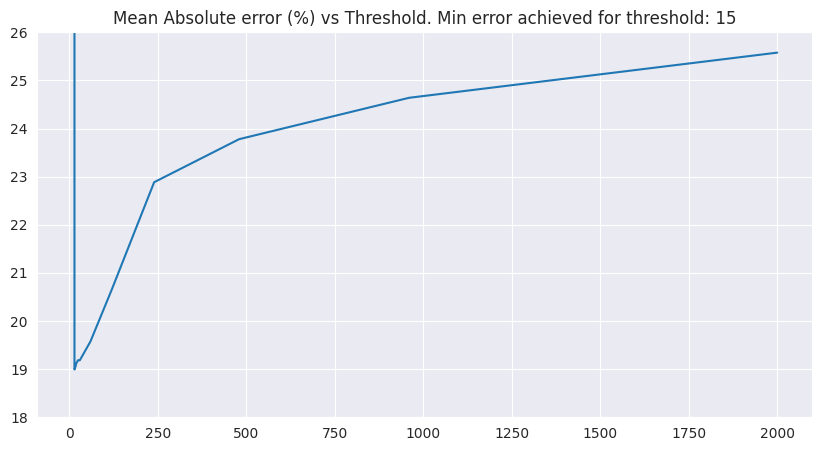

In [131]:
plt.figure(figsize=(10,5))
plt.plot(threshs, np.array(maes)*100)
plt.ylim([18,26])
plt.title('Mean Absolute error (%) vs Threshold. Min error achieved for threshold: 15')
plt.savefig('../plots/threshold_linreg.png', bbox_inches='tight')

In [137]:
train['log_price'] = train.raw_price.apply(np.log)
test['log_price'] = test.raw_price.apply(np.log)


In [136]:
dict_linreg_models = {}
dict_linreg_brands = {}
for group in tqdm(train.group_model_level.unique()):
    scaler = StandardScaler()
    X = scaler.fit_transform(((train.loc[train.group_model_level == group,cols_to_keep])))
    X = sm.add_constant(X)
    linreg = sm.OLS(train.loc[train.group_model_level == group,'log_price'],X)
    dict_linreg_models[group] = [linreg.fit(), scaler, train[train.group_model_level == group].shape[0]]

for group in tqdm(train.brand.unique()):
    scaler = StandardScaler()
    X = scaler.fit_transform((train.loc[train.brand == group,cols_to_keep]))
    X = sm.add_constant(X)
    linreg = sm.OLS(train.loc[train.brand == group,'log_price'],X)
    dict_linreg_brands[group] = [linreg.fit(), scaler,  train[train.brand == group].shape[0]]



100%|██████████| 69/69 [00:00<00:00, 71.65it/s]


In [142]:
test['pred_linreg'] = test.apply(lambda x : np.exp(predict_linreg(x, thresh=20)),axis=1)

In [143]:
test['residual_linreg'] = test.raw_price - test.pred_linreg
test['abs_residual_linreg'] = np.abs(test.raw_price - test.pred_linreg)
test['ape_linreg'] = np.abs(test.raw_price - test.pred_linreg)/np.abs(test.raw_price)

In [144]:
print(f"MAPE: {test.ape_linreg.mean()}")
print(f"MAE: {test.ape_linreg.mean()}")

MAPE: 0.19179289140755695
MAE: 0.19179289140755695


In [146]:
print(test.ape_linreg.describe([0.01,0.1,0.9,0.95,0.99]).to_markdown())

|       |      ape_linreg |
|:------|----------------:|
| count | 20286           |
| mean  |     0.191793    |
| std   |     0.513715    |
| min   |     1.89398e-05 |
| 1%    |     0.00207039  |
| 10%   |     0.0218623   |
| 50%   |     0.122594    |
| 90%   |     0.383605    |
| 95%   |     0.530776    |
| 99%   |     1.14574     |
| max   |    51.6949      |


In [147]:
test.loc[:,['id','pred_linreg', 'residual_linreg','abs_residual_linreg', 'ape_linreg']].to_csv('../data/experiment_results/linreg_res.csv')

In [670]:
test_validation.loc[90613].to_frame().T

,lat,lon,uuid,is_new,label,model_stub,thumbs,id,price_debatable,user_id,...,is_metallic,comfort_options,safety_driver_assistance_options,performance_handling_options,utility_options,premium_options,infotainment_options,group_model_year_level,group_model_level,group_year_level
90613,38.011675,23.865407,4aa6ce8a-c23e-4e1a-a816-6d040d2e9ced,False,NaN,Mercedes-Benz S 600 '06 V 12,"{'count': 27, 'urls': ['https://static.car.gr/341127684_0_m.jpg', 'https://static.car.gr/341127684_1_m.jpg', 'https://static.car.gr/341127684_2_m.jpg', 'https://static.car.gr/341127684_3_m.jpg', 'https://static.car.gr/341127684_4_m.jpg', 'https://static.car.gr/341127684_5_m.jpg', 'https://static.car.gr/341127684_6_m.jpg', 'https://static.car.gr/341127684_7_m.jpg', 'https://static.car.gr/341127684_8_m.jpg', 'https://static.car.gr/341127684_9_m.jpg', 'https://static.car.gr/341127684_a_m.jpg', 'https://static.car.gr/341127684_b_m.jpg', 'https://static.car.gr/341127684_c_m.jpg', 'https://static.car.gr/341127684_d_m.jpg', 'https://static.car.gr/341127684_e_m.jpg', 'https://static.car.gr/341127684_f_m.jpg', 'https://static.car.gr/341127684_g_m.jpg', 'https://static.car.gr/341127684_h_m.jpg', 'https://static.car.gr/341127684_i_m.jpg', 'https://static.car.gr/341127684_j_m.jpg', 'https://static.car.gr/341127684_k_m.jpg', 'https://static.car.gr/341127684_l_m.jpg', 'https://static.car.gr/341127684_m_m.jpg', 'https://static.car.gr/341127684_n_m.jpg', 'https://static.car.gr/341127684_o_m.jpg', 'https://static.car.gr/341127684_p_m.jpg', 'https://static.car.gr/341127684_q_m.jpg']}",341127684,True,1010540,...,True,0.555556,0.315789,0.4,0.333333,0.3,0.181818,mercedes-benz_s 600_2006,mercedes-benz_s 600,mercedes-benz_2006


In [148]:
test['model_level_used'] = test.groupby('group_model_level')['group_model_level'].transform('count') >= 20

(0.0, 0.8)

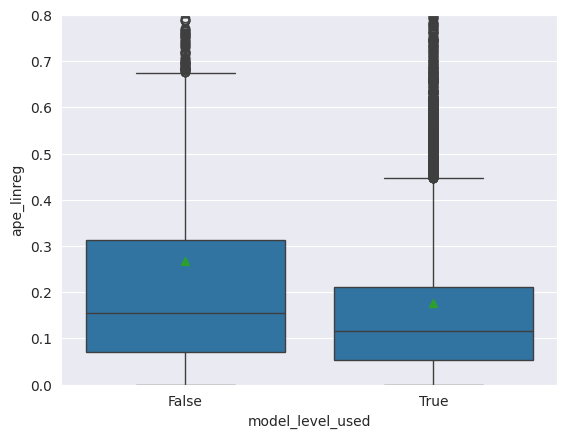

In [149]:
sns.boxplot(data=test, x='model_level_used', y='ape_linreg', showmeans=True)
plt.ylim([0,0.8])

In [690]:
test_val_linreg.shape

(12172, 25)

In [689]:
qs = [0.01,0.1,0.9,0.95,0.99]
pd.concat([test_val_linreg.loc[test_val_linreg.model_level_used,'ape'].describe(qs),test_val_linreg.loc[~(test_val_linreg.model_level_used),'ape'].describe(qs)],axis=1)

,ape,ape
count,9147.000000,3.025000e+03
mean,0.172345,3.050763e-01
std,0.679417,3.546764e+00
min,0.000011,3.410605e-15
1%,0.001885,2.702271e-03
10%,0.019425,2.560458e-02
50%,0.114331,1.473802e-01
90%,0.345653,4.830858e-01
95%,0.467544,6.781391e-01
99%,0.908617,1.922034e+00


In [691]:
#We observe larger errors when regressions fitted at the brand level is used. This is logical as we observed clearer linear relationships at the model level and also because the model is a critical characteristic for estimating the price of a car.

(0.0, 1.0)

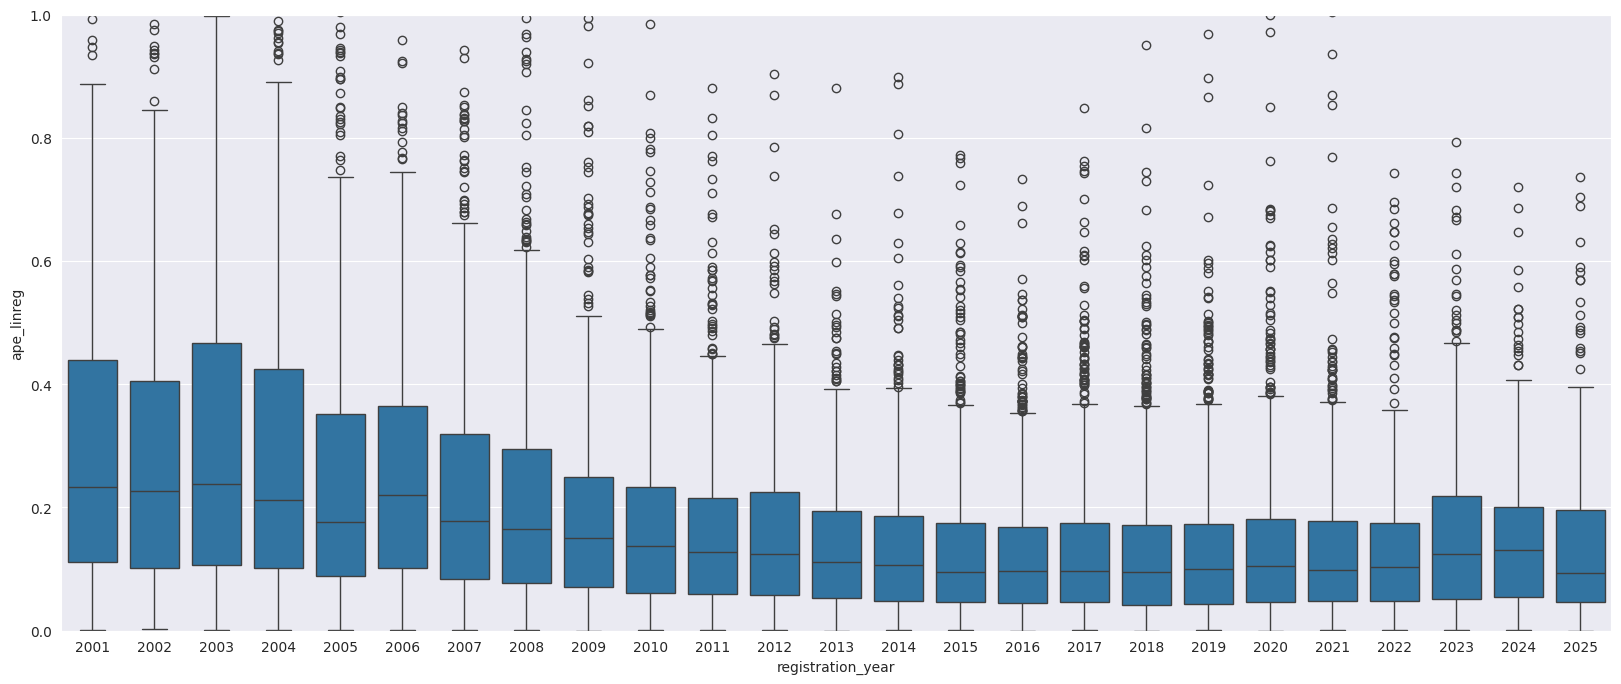

In [151]:
plt.figure(figsize=(20,8))
sns.boxplot(data=test, x='registration_year', y='ape_linreg')
plt.ylim([0,1])

(0.0, 20000.0)

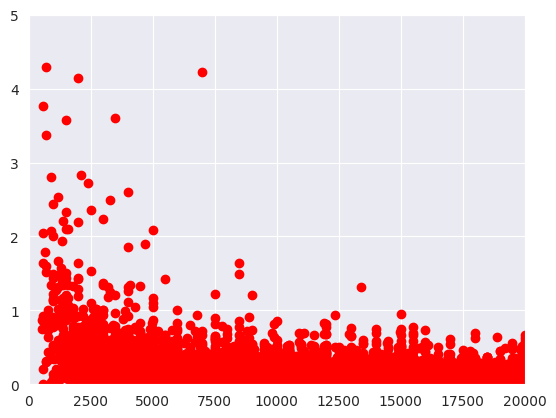

In [521]:
plt.scatter(test_val_linreg.raw_price,test_val_linreg.ape,c='red')
plt.ylim([0,5])
plt.xlim([0,20000])

(0.0, 0.5)

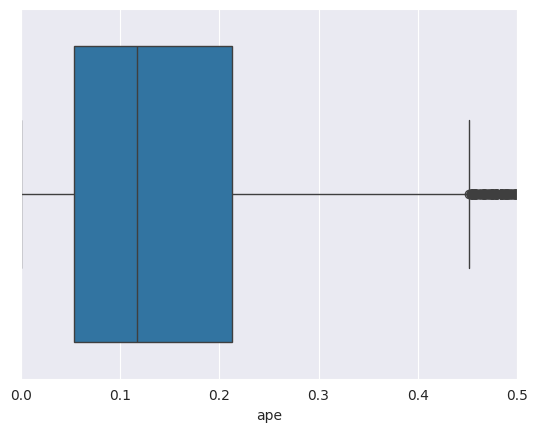

In [530]:
sns.boxplot(test_val_linreg.ape, orient='h')
plt.xlim([0,0.5])

In [532]:
test_val_linreg.ape.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count    1.060100e+04
mean     1.769194e-01
std      6.443560e-01
min      7.579123e-16
1%       1.848119e-03
5%       1.040729e-02
10%      1.995749e-02
25%      5.315338e-02
50%      1.168552e-01
75%      2.127086e-01
90%      3.497346e-01
95%      4.842180e-01
99%      9.844116e-01
max      6.182568e+01
Name: ape, dtype: float64

(-20000.0, 20000.0)

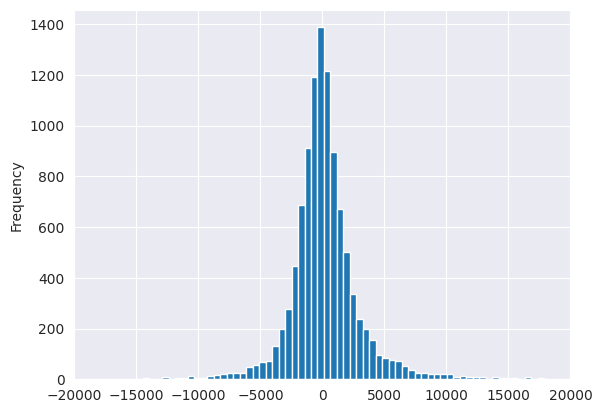

In [537]:
test_val_linreg.residual.plot(kind='hist',bins=500)
plt.xlim([-20000,20000])